In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
from itertools import product
import gensim
import pickle

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage

## Third Patient Set (Race)

In [4]:
#load patient vectors from HMP-T2D
vec_p1 = pickle.load(open("r_vec_p1.p", "rb"))
vec_p2 = pickle.load(open("r_vec_p2.p", "rb"))
vec_p3 = pickle.load(open("r_vec_p3.p", "rb"))
vec_p4 = pickle.load(open("r_vec_p4.p", "rb"))

In [7]:
#a vector (length 10) for each sequence that is an average of all 6 'versions' of that sequence
#should be equal to number of original reads per patient
print('Vectors in P1:', len(vec_p1))
print('Vectors in P2:', len(vec_p2))
print('Vectors in P3:', len(vec_p3))
print('Vectors in P4:', len(vec_p4))

Vectors in P1: 18215
Vectors in P2: 19201
Vectors in P3: 20000
Vectors in P4: 19417


In [6]:
#I'm not sure why p3 had over double the reads of the other patients
#randomly sampled 20,000 from P3 in order to facilitate completion
np.random.seed(42)
ind_p3 = np.random.choice(range(43966), 20000).tolist()

vec_p3 = [vec_p3[i] for i in ind_p3]

## PCA

In [14]:
X = np.concatenate((vec_p1, vec_p2, vec_p3, vec_p4))
y = np.concatenate((np.ones(18215), np.full(19201, 2), np.full(20000, 3), np.full(19417, 4)))

In [15]:
# Take all of the data and plot it on 2 dimensions
pca = PCA(n_components=2)
pca.fit(X)
pcafeatures_train = pca.transform(X)

In [16]:
# Create a plot of the PCA results
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()

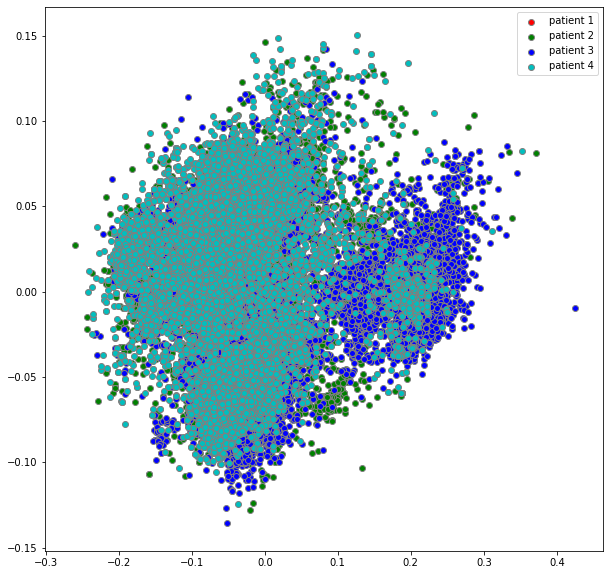

In [17]:
# plot PC1 vs PC2 of all the sequences
plot_PCA_2D(pcafeatures_train, target=y, target_names=['patient 1', 'patient 2', 'patient 3', 'patient 4'])

## Clustering

### Heirarchical

[(0, 4600), (1, 2048), (2, 1932), (3, 5491), (4, 4144)]
[(0, 6767), (1, 6006), (2, 1326), (3, 3763), (4, 1339)]
[(0, 6088), (1, 7673), (2, 2193), (3, 553), (4, 3493)]
[(0, 5419), (1, 4044), (2, 5818), (3, 806), (4, 3330)]


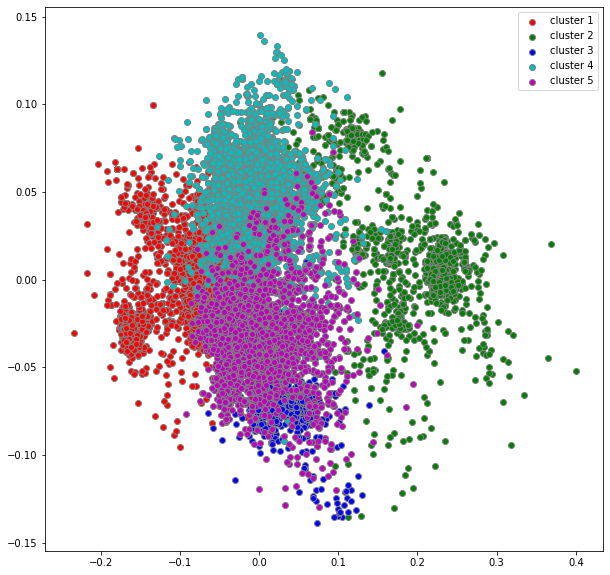

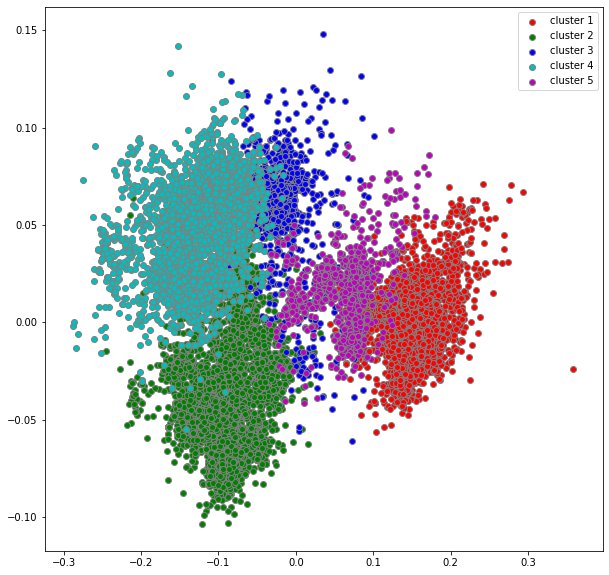

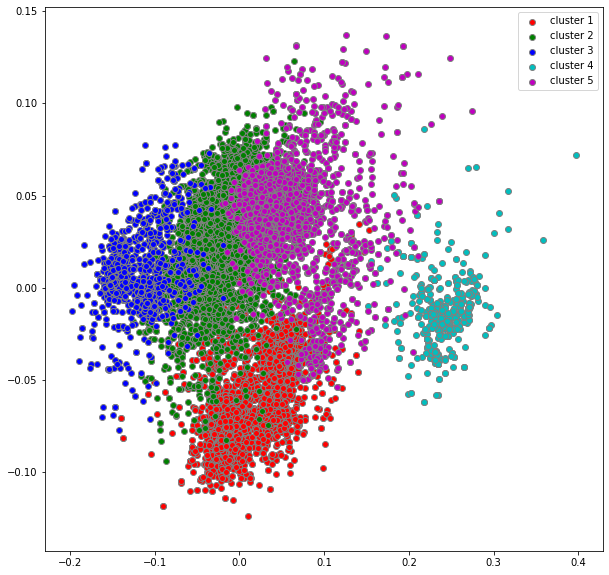

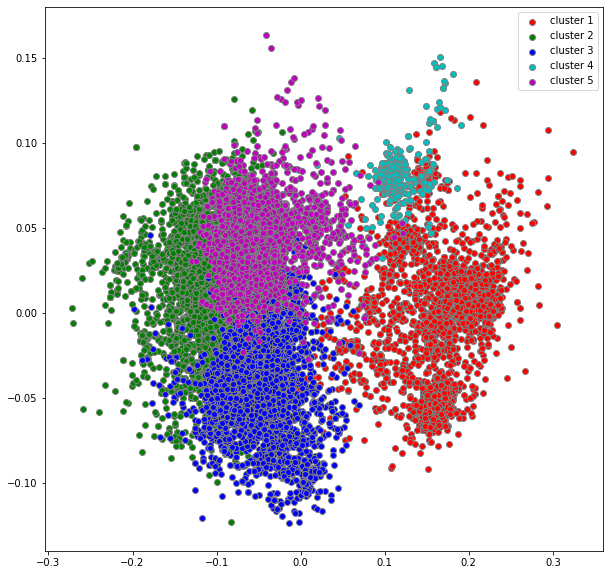

In [18]:
#get cluster labels and determine number of points within each cluster

hc_labels = []
children = []

for ind,patient in enumerate([vec_p1, vec_p2, vec_p3, vec_p4]):
    hc = AgglomerativeClustering(linkage='ward', n_clusters=5)
    hc.fit(patient)
    labels = hc.labels_
    y = np.bincount(labels)
    ii = np.nonzero(y)[0]
    print(list(zip(ii,y[ii])))
    hc_labels.append(labels)
    children.append(hc.children_)
    
    #plot using pc1/pc2
    pca = PCA(n_components=2)
    pca.fit(patient)
    pcafeatures_train = pca.transform(patient)

    plot_PCA_2D(pcafeatures_train, target=hc_labels[ind], 
            target_names=['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5'])

In [19]:
def find_nearest(vectors, center):
    current_min = (0, 1)
    for i, vector in enumerate(vectors):
        new_min = (i, sum(np.abs(np.subtract(np.asarray(vector), np.asarray(center)))))
        if new_min[1] < current_min[1]:
            current_min = new_min
    return current_min

In [20]:
#find "centers" of agglomerative clustering
#actually it's the average of all points of that cluster in the 10-dim space
#find_nearest returns the vector that is "nearest" to the determined "center"
def find_center(labels, num_clusters, vectors):
    hc_centers = []
    actual_centers = []
    for clust in range(num_clusters):
        clust_ind = [i for i, x in enumerate(labels) if x == clust]
        vec_ind = [vectors[i] for i in clust_ind]
        hc_centers.append(sum(vec_ind)/len(clust_ind))
    
    for center in hc_centers:
        actual_centers.append(find_nearest(vectors, center))
    return actual_centers

In [21]:
#this returns the index and distance from the calculated 'center' of the representative sequences for each cluster
#these can be plugged back into the original data in order to BLAST the representative sequences to interpret species 
for ind, patient in enumerate([vec_p1, vec_p2, vec_p3, vec_p4]):
    cents = find_center(hc_labels[ind], 5, patient)
    print('Centers for Patient', ind+1)
    print(cents)

Centers for Patient 1
[(4701, 0.0547172911465168), (10620, 0.0858825296163559), (2807, 0.04124520719051361), (10037, 0.07197865471243858), (10068, 0.05104479193687439)]
Centers for Patient 2
[(14782, 0.06327742338180542), (7859, 0.062048111110925674), (14420, 0.06050773710012436), (7285, 0.057487405836582184), (923, 0.04197736084461212)]
Centers for Patient 3
[(7905, 0.06606641784310341), (926, 0.051853958517313004), (8920, 0.10917359218001366), (12488, 0.08015167713165283), (2681, 0.04277834855020046)]
Centers for Patient 4
[(15989, 0.07369545102119446), (7592, 0.054174039512872696), (17115, 0.04659348353743553), (1483, 0.011794349644333124), (3182, 0.06017076596617699)]
